# ML model generation

This notebook creates and trains a simple sine wave detection model by following the example provided at https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/README.md. At the end, the model is exported as `model.bin`.

In [13]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import struct

save_model = False

In [2]:
def get_data(seed=0):
    ''' generate data for the model '''
    np.random.seed(seed)
    x = np.random.uniform(low=0, high=2*np.pi, size=1000)
    np.random.shuffle(x)
    x = torch.from_numpy(x).view(-1,1).float()
    
    y = torch.sin(x)

    return x,y

In [3]:
class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()
        self.dim = dim
        self.layers = nn.ModuleList([nn.Linear(1, dim), 
                                    nn.Linear(dim, dim)])
        self.activation = nn.ReLU()
        self.out = nn.Linear(dim, 1)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        
        x = self.out(x)
        
        return x

0.4938150644302368
0.0007496473263017833
9.792901983018965e-05
6.613692676182836e-05
6.751218461431563e-05
5.037201117374934e-05
6.468529318226501e-05
4.8870013415580615e-05
4.718550917459652e-05
4.711628571385518e-05


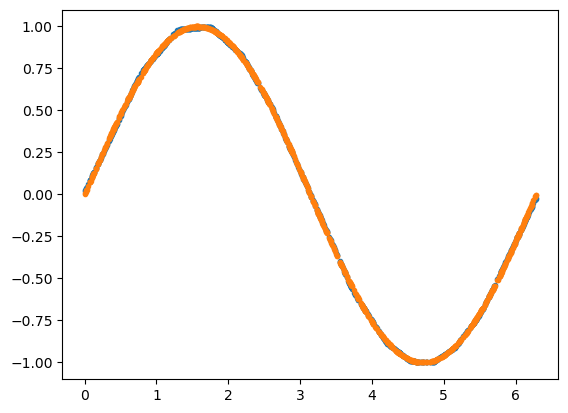

In [8]:
# training
model = Model(16)
loss_fn = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.002)
x,y = get_data()

for epoch in range(10000):
    opt.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    opt.step()
    if epoch%1000==0:
        print(loss.item())

xval, yval = get_data()
plt.plot(xval.numpy(), model(xval).detach().numpy(), ".")
plt.plot(xval.numpy(), yval.numpy(), ".")


In [9]:
def read_parameters(model):
    ''' read model.bin and assign parameters to the model '''
    f = open("model.bin", "rb")
    dim = struct.unpack('i', f.read(4))[0]
    f.seek(256)
    wi = torch.tensor(struct.unpack('f'*dim, f.read(4*dim))).view(dim,1)
    wh = torch.tensor(struct.unpack('f'*dim*dim, f.read(4*dim*dim))).view(dim,dim)
    wo = torch.tensor(struct.unpack('f'*dim, f.read(4*dim))).view(1,dim)
    bi = torch.tensor(struct.unpack('f'*dim, f.read(4*dim)))
    bh = torch.tensor(struct.unpack('f'*dim, f.read(4*dim)))
    bo = torch.tensor(struct.unpack('f', f.read(4)))
    f.close()
    
    i = 0
    params = [wi, bi, wh, bh, wo, bo]
    for p in model.parameters():
        p.data = params[i]
        i += 1
    
    return model

In [12]:
# export the model
def serialize_fp32(file, tensor):
    """ write one fp32 tensor to file that is open in wb mode """
    d = tensor.detach().cpu().view(-1).to(torch.float32).numpy()
    b = struct.pack(f'{len(d)}f', *d)
    file.write(b)
    
def export_model(model, filepath = "model.bin"):
    ''' export the model to filepath '''
    f = open(filepath, "wb")
    # write the model structure 
    header = struct.pack("i", model.dim)
    f.write(header) 
    pad = 256 - f.tell() # pad rest with zeros
    assert pad >= 0
    f.write(b'\0'*pad)
    # write the model weights and biases
    weights = [*[layer.weight for layer in model.layers], model.out.weight]
    bias = [*[layer.bias for layer in model.layers], model.out.bias]
    
    for w in weights:
        serialize_fp32(f, w)
    
    for b in bias:
        serialize_fp32(f, b)

    f.close()
    print(f"wrote {filepath}")
    
if save_model:
    export_model(model)

wrote model.bin


In [15]:
def serialize_int8(file, tensor):
    """ write one int8 tensor to file that is open in wb mode """
    d = tensor.detach().cpu().view(-1).numpy().astype(np.int8)
    b = struct.pack(f'{len(d)}b', *d)
    file.write(b)

def quantize_q80(w, group_size):
    """
    takes a tensor and returns the Q8_0 quantized version
    i.e. symmetric quantization into int8, range [-127,127]
    """
    assert w.numel() % group_size == 0
    ori_shape = w.shape
    w = w.float() # convert to float32
    w = w.reshape(-1, group_size)
    # find the max in each group
    wmax = torch.abs(w).max(dim=1).values
    # calculate the scaling factor such that float = quant * scale
    scale = wmax / 127.0
    # scale into range [-127, 127]
    quant = w / scale[:,None]
    # round to nearest integer
    int8val = torch.round(quant).to(torch.int8)
    # dequantize by rescaling
    fp32val = (int8val.float() * scale[:,None]).view(-1)
    fp32valr = fp32val.reshape(-1, group_size)
    # calculate the max error in each group
    err = torch.abs(fp32valr - w).max(dim=1).values
    # find the max error across all groups
    maxerr = err.max().item()
    return int8val, scale, maxerr

def export_modelq8(model = None, filepath = "modelq8.bin"):
    ''' read a model from model.bin and export a quatized (int8) model to filepath '''
    if model==None:
        model = read_parameters(Model(16))
    # group size in quantizationlarger group size results in higher accuracy and larger cost in memory (check why)
    group_size = 16 
        
    f = open(filepath, "wb")
    # write the model structure 
    header = struct.pack("ii", model.dim, group_size)
    f.write(header) 
    pad = 256 - f.tell() # pad rest with zeros
    assert pad >= 0
    f.write(b'\0'*pad)
    # write the model weights and biases
    weights = [*[layer.weight for layer in model.layers], model.out.weight]
    bias = [layer.bias for layer in model.layers]

    # now let's write out all the params that we are quantizing to Q8_0
    # note we skip classifier weights, which are shared with the embedding
    assert model.dim%group_size == 0
    ew = []
    for i, w in enumerate(weights):
        # quantize this weight
        q, s, err = quantize_q80(w, group_size)
        # save the int8 weights to file
        serialize_int8(f, q) # save the tensor in int8
        serialize_fp32(f, s) # save scale factors
        # logging
        ew.append((err, w.shape))
        print(f"{i+1}/{len(weights)} quantized {tuple(w.shape)} to Q8_0 with max error {err}")
        
    for i, b in enumerate(bias):
        # quantize this bias
        q, s, err = quantize_q80(b, group_size)
        # save the int8 biases to file
        serialize_int8(f, q) # save the tensor in int8
        serialize_fp32(f, s) # save scale factors
        # logging
        ew.append((err, w.shape))
        print(f"{i+1}/{len(bias)} quantized {tuple(b.shape)} to Q8_0 with max error {err}")
    
    # quantize the bias of the output layer separately because its length is 1
    s = torch.abs(model.out.bias) / 127.0
    serialize_int8(f, torch.tensor(127).to(torch.int8))
    serialize_fp32(f, s)
    # print the highest error across all weights, should be very small, e.g. O(~0.001)
    ew.sort(reverse=True)
    print(f"max quantization group error across all weights: {ew[0][0]}")
    f.close()
    print(f"wrote {filepath}")

In [83]:
def write_weights():
    ''' write the model parameters to check if "model.bin" is written correctly '''

    f = open("model.bin", "rb")
    dim = struct.unpack('i', f.read(4))[0]
    f.seek(256)
    wi = struct.unpack('f'*dim, f.read(4*dim))
    wh = struct.unpack('f'*dim*dim, f.read(4*dim*dim))
    wo = struct.unpack('f'*dim, f.read(4*dim))
    bi = struct.unpack('f'*dim, f.read(4*dim))
    bh = struct.unpack('f'*dim, f.read(4*dim))
    bo = struct.unpack('f', f.read(4))
    f.close()
    
    f = open("weightsp.txt", "w")
    weights = [*wi, *wh, *wo, *bi, *bh, *bo]
    for w in weights:
        f.write("{}\n".format(w))
    f.close()

In [47]:
def write_output(model):
    ''' write model outputs to compare these to model outputs in C '''
    
    model = read_parameters(model)

    inputs = torch.tensor([0.001, 1.57, 3.14, 6.28]).view(-1,1);
    
    f = open("outputp.txt", "w")
    outputs = model(inputs).detach().cpu()
    for out in outputs:
        f.write("{}\n".format(float(out)))
    f.close()